In [44]:
import sympy as sm
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import math
from copy import deepcopy
import itertools

In [45]:
round_count = 2
cer = 10
eps = 1e-6
lam = 10
steps = 250

files = [
    'gpa-1.txt',
    'gpa-2.txt',
    'undetermine-system.txt'
]

In [46]:
def cacl_jac(all_symbols=[], equations=[]):
    jacobi = sm.zeros(len(all_symbols), len(all_symbols))
    for var_i in range(len(all_symbols)):
        var = all_symbols[var_i]
        for eq_i in range(len(equations)):
            eq = equations[eq_i]
            jacobi[eq_i, var_i] = sm.diff(eq, var)
        
    jacobian = jacobi.det()
    
    return jacobi, jacobian

In [47]:
def disp_graph_with_custom_labels(gr=None, 
                                  nodes_labels={}, 
                                  edges_labels={},
                                  fig_size=8,
                                  node_label=None, 
                                  edge_label=None):
    plt.figure(figsize=(fig_size, fig_size))
    
    if not edge_label == None and not edge_label == '':
        edges_labels = nx.get_edge_attributes(G=gr, name=edge_label)
#         print('edge attr for print : ' + edge_label)
        
    if not node_label == None and not node_label == '':
        nodes_labels = nx.get_node_attributes(G=gr, name=node_label)
#         print('node attr for print : ' + node_label)
        
    
#     print(nodes_labels)
#     print(edges_labels)
    
    layout = nx.shell_layout(gr)
    
    nx.draw(G=gr, pos=layout, node_size=1500)
    nx.draw_networkx_edge_labels(G=gr, pos=layout, edge_labels=edges_labels, font_family='sans-serif')
    nx.draw_networkx_labels(G=gr, pos=layout, labels=nodes_labels, font_family='sans-serif')
    plt.show()

In [48]:
def subs_to_graph_new_values(gr=None, values=[]):
    q = nx.get_edge_attributes(G=gr, name='q')
    p = nx.get_node_attributes(G=gr, name='p')

    for sub_expr in values:
        sym = sub_expr[0]
        val = round(sub_expr[1], round_count)

        for edge_param in list(q.items()):
            if sym == str(edge_param[1]):
                q[edge_param[0]] = val

        for node_param in list(p.items()):
            if sym == str(node_param[1]):
                p[node_param[0]] = val

#     print(q)
#     print(p)

    nx.set_edge_attributes(G=gr, name='q', values=q)
    nx.set_node_attributes(G=gr, name='p', values=p)

In [49]:
def disp_graph(gr=None, edge_label='q',
               node_label='p',
               fig_size=8):
    
    plt.figure(figsize=(fig_size, fig_size))
    
    edges_labels = nx.get_edge_attributes(G=gr, name=edge_label)
    nodes_labels = nx.get_node_attributes(G=gr, name=node_label)
    
    layout = nx.shell_layout(gr)
    
    nx.draw(G=gr, pos=layout, node_size=1500)
    nx.draw_networkx_edge_labels(G=gr, pos=layout, edge_labels=edges_labels, font_family='sans-serif')
    nx.draw_networkx_labels(G=gr, pos=layout, labels=nodes_labels, font_family='sans-serif')
    plt.show()

In [50]:
def read_graph(path=''):
    all_symbols = []

    gpa = nx.DiGraph()

    with open(path, 'r') as input:
        line = input.readline()

        params = list(map(lambda x : int(x), line.split(' ')))
        V, E = params[0], params[1]

        graph_params = {
            'nodes' : dict(),
            'edges' : dict()
        }

        for i in range(V):
            params = list(map(lambda x : int(x), input.readline().split(' ')))
            node = params[0]

    #         print(params, i, V)

            if len(params) == 1:
                p_i = sm.symbols('p' + str(i + 1))
                all_symbols.append(p_i)
            else:
                p_i = params[1]
            gpa.add_node(node, p=p_i, code=str(i + 1))

        for i in range(E):
            params = list(map(lambda x : int(x), input.readline().split(' ')))

    #         print(params, i, E)

            u = params[0]
            v = params[1]
            l = params[2]
            d = params[3]

            if len(params) == 4:
                q_i = sm.symbols('q' + str(i + 1))
                all_symbols.append(q_i)
            else:
                q_i = params[4]
            gpa.add_edge(u=u, v=v, q=q_i, L=l, D=d, code=str(i + 1))

#     disp_graph(gr=gpa, edge_label='q', node_label='p', fig_size=5)
    return gpa, all_symbols

In [51]:
def get_equations(gr=None, all_symbols=[]):
    q = nx.get_edge_attributes(G=gr, name='q')
    p = nx.get_node_attributes(G=gr, name='p')
    l = nx.get_edge_attributes(G=gr, name='L')
    d = nx.get_edge_attributes(G=gr, name='D')
    
    equations = []

    for edge, param in q.items():
        qc = param
        pcs = p[edge[0]]
        pcf = p[edge[1]]
        dc = d[edge]
        lc = l[edge]

        counter = 0

        eq = pcs * pcs - pcf * pcf - qc * qc * lc * dc ** 5

        fl = True
        for sym in all_symbols:
            expr = sm.diff(eq, sym)
            fl = fl and expr == 0

    #     print(eq, fl, counter)

        if not fl:
            equations.append(eq)

    edge_list = list(gr.edges())
    temp = np.zeros((len(edge_list), 2))
    for i in range(len(edge_list)):
        edge = edge_list[i]
        temp[i][0] = edge[0]
        temp[i][1] = edge[1]

    edges = temp

    for node in gr.nodes:

        eq = 0
        counter = 0
        for temp_edge in edges:
            if temp_edge[0] == node:
                qc = q[(temp_edge[0], temp_edge[1])]
                eq += qc
                counter += 1
            if temp_edge[1] == node:
                qc = q[(temp_edge[0], temp_edge[1])]
                eq -= qc
                counter += 1

        fl = True
        for sym in all_symbols:
            expr = sm.diff(eq, sym)
            fl = fl and expr == 0

    #     print(eq, fl, counter)

        if not fl and counter > 1:
            equations.append(eq)

    for i in range(len(equations)):
        print('equation ' + str(i + 1) + ' : ' + str(equations[i]))

#     print('vars : ', all_symbols)

    return equations

In [52]:
def get_newton_equations(equations=[], all_symbols=[]):
    jacobi, jacobian = cacl_jac(all_symbols=all_symbols, equations=equations)
    
    eqs = []
    eq = sm.Matrix(deepcopy(equations))
    
    for i in range(len(all_symbols)):
        f_i = deepcopy(jacobi)
        f_i[:, i] = eq
        f_i = f_i.det()

        f_i = sm.simplify(f_i / jacobian)

        eqs.append(f_i)
        
    return eqs

In [53]:
def subs(values=[], eqs=[]):  
    ans = [round(float(eq.subs(values)), round_count) for eq in eqs]
    
#     print(ans)
    
    return ans

In [54]:
def solving(values=[], eqs=[], steps=25, eps=0.001):
    cer = 1
    ers = []

    while cer > eps and steps > 0:
        er = []
        try:
            ans = subs(eqs=eqs, values=values)
#             print(ans)
            
            for i in range(len(values)):
                values[i][1] = values[i][1] - ans[i]
                
#                 print(ans[i])
                er.append(math.fabs(ans[i]))

            er = np.linalg.norm(np.array(er))
            ers.append(er)
            cer = er

            steps -= 1

        except Exception as ex:
            print('Ooops', steps, cer, ex)
            break
    
    return values, ers

# Реализация метода Ньютона

In [55]:
def calc(path='', values=[]):
    gpa, all_symbols = read_graph(path=path)
    
    disp_graph_with_custom_labels(gr=gpa, edge_label='q', node_label='p')
    
    equations = get_equations(gr=gpa, all_symbols=all_symbols)
    
    print()
    print('Переменных :', len(all_symbols))
    print(all_symbols)
    print('Уравнений :', len(equations))
    print()
    
    eqs = get_newton_equations(all_symbols=all_symbols, equations=equations)
    
    values, ers = solving(values=values, eqs=eqs)

    subs_to_graph_new_values(values=values, gr=gpa)
    disp_graph(gr=gpa, edge_label='q', node_label='p')

    plt.figure(figsize=(10, 10))
    plt.plot(range(len(ers)), ers, 'b')
    plt.plot(range(len(ers)), ers, 'ro')
    plt.ylabel(s='Норма изменения')
    plt.xlabel(s='Номер шага')
    plt.grid()
    plt.show()

#     print('Результат : ')
#     pprint(values)

    print('\nError : ' + str(min(ers)))
    
    return gpa

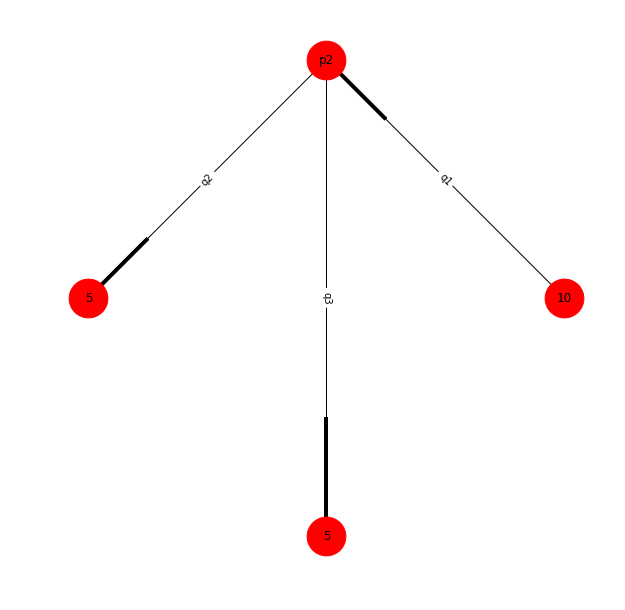

equation 1 : -p2**2 - 12*q1**2 + 100
equation 2 : p2**2 - 12*q2**2 - 25
equation 3 : p2**2 - 12*q3**2 - 25
equation 4 : -q1 + q2 + q3

Переменных : 4
[p2, q1, q2, q3]
Уравнений : 4



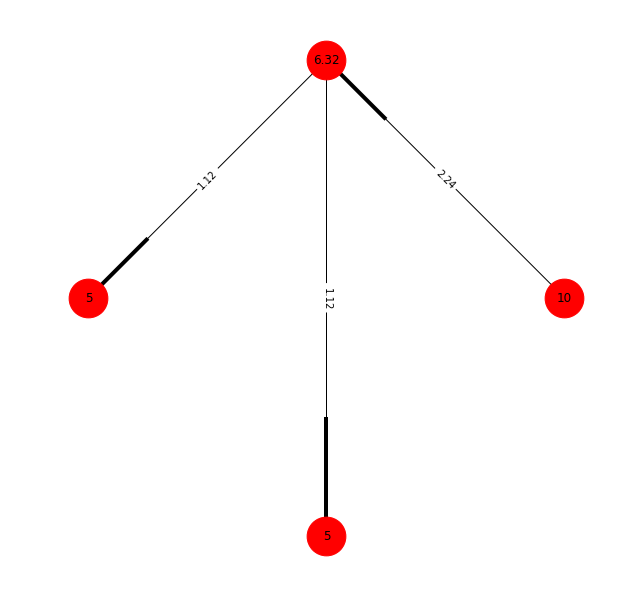

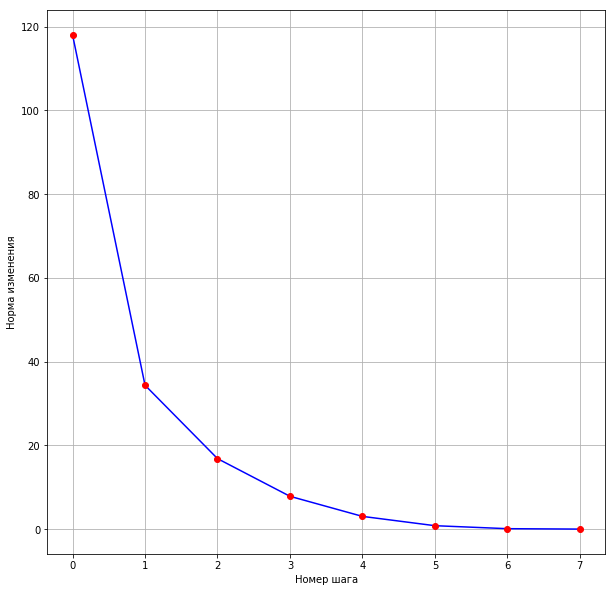


Error : 0.0


In [58]:
# #Для gpa-1.txt
# values = [
#     ['p2', 160],
#     ['p4', 160],
#     ['q1', 60],
#     ['q2', 50],
#     ['q3', 50],
#     ['q4', 50],
#     ['q5', 54],
#     ['q6', 55]
# ]

#Для gpa-2.txt
values = [
    ['p2', 160],
    ['q1', 60],
    ['q2', 50],
    ['q3', 50]
]

gpa = calc(path='gpa-2.txt', values=values)